In [2]:
import pandas as pd

df = pd.read_csv('/kaggle/input/fake-news-combined-cleaned/news_cleaned.csv')

In [3]:
print(df['clean_text'].isna().sum())

718


In [4]:
percentage = (df['clean_text'].isna().sum() / len(df)) * 100
print(f"NaN values represent {percentage:.2f}% of the dataset")

print(df['label'].isna().sum())

NaN values represent 1.60% of the dataset
0


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Remove rows with NaN values in the 'clean_text' column
df_clean = df.dropna(subset=['clean_text'])

# Now proceed with TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df_clean['clean_text']).toarray()
y = df_clean['label'].values

# Check the shapes to confirm everything worked
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (44180, 5000)
Target vector shape: (44180,)


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# ✅ Fill NaN values with empty string
df['clean_text'] = df['clean_text'].fillna('')

# ✅ TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text']).toarray()

# ✅ Labels
y = df['label'].values


In [7]:
tfidf = TfidfVectorizer(
    max_features=10000,          # Increased for better vocab coverage
    ngram_range=(1, 2),          # Use unigrams and bigrams
    stop_words='english',        # Built-in stopword removal
    sublinear_tf=True            # Apply sublinear tf scaling (1 + log(tf))
)
X = tfidf.fit_transform(df['clean_text']).toarray()


In [8]:
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))
df['title_length'] = df['title'].apply(lambda x: len(str(x).split()))
df['num_exclamations'] = df['text'].apply(lambda x: x.count('!'))

In [9]:
import numpy as np

meta_features = df[['text_length', 'title_length', 'num_exclamations']].values
X_combined = np.hstack((X, meta_features))


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=8000)  # or any threshold
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)


In [12]:
print("📐 TF-IDF Feature Shape:", X_test.shape)
print("📐 Metadata Feature Shape:", meta_features.shape)
print("📐 Final Combined Feature Shape (X):", X.shape)
print("🎯 Target Shape (y):", y.shape)

📐 TF-IDF Feature Shape: (8980, 8000)
📐 Metadata Feature Shape: (44898, 3)
📐 Final Combined Feature Shape (X): (44898, 10000)
🎯 Target Shape (y): (44898,)


In [13]:
print("🧪 Final Train Shape:", X_train.shape)
print("🧪 Final Test Shape:", X_test.shape)


🧪 Final Train Shape: (35918, 8000)
🧪 Final Test Shape: (8980, 8000)


Accuracy: 0.9963251670378619
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



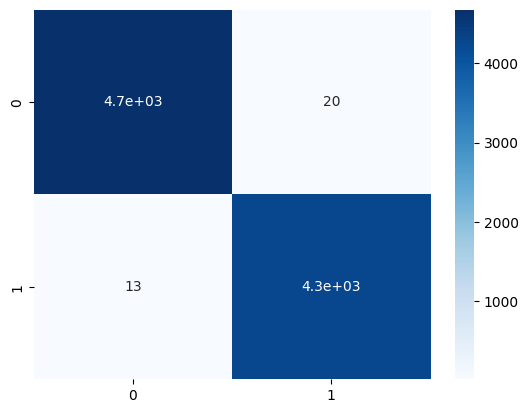

['news_classification_model.pkl']

In [14]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import joblib

# (Optional) Scale the data to help convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model with scaled data (or use unscaled data if you prefer)
model = LogisticRegression(max_iter=500)  # Increased max_iter to allow convergence
model.fit(X_train_scaled, y_train)  # Or X_train if you're not scaling

# Make predictions
y_pred = model.predict(X_test_scaled)  # Or X_test if you're not scaling

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Generate confusion matrix and plot
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.show()

# Save the trained model for future use
joblib.dump(model, 'news_classification_model.pkl')


XGBoost Accuracy: 0.9979955456570155

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



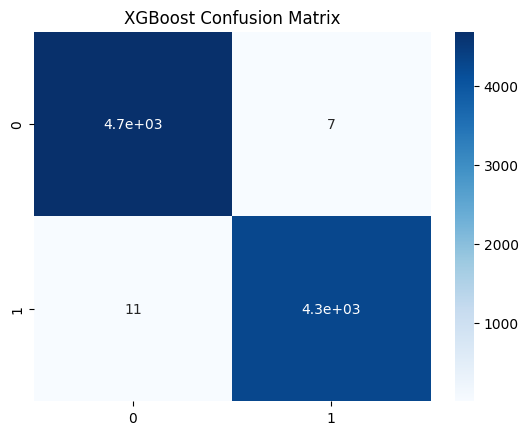

['xgboost_news_classifier.pkl']

In [15]:
# Import necessary libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Initialize and train XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # assuming binary classification
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_scaled)

# Evaluate model
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()

# Save the model
joblib.dump(xgb_model, 'xgboost_news_classifier.pkl')